# The Battle of Neighborhoods
**Exploring Soccer for Seeking Field Business Opportunity**  
Coursera Applied Data Science Capstone Project  
I-Hsin Lin, 1 July 2021

At a new capital location for Indonesia

## Introduction

### Background Information

The Government of Indonesia has announced that the nation's capital will be moved to the East Kalimantan region. The location of the new capital city is located in part of North Penajam Paser Regency and partly in Kutai Kertanegara Regency, East Kalimantan. The government considered the location due to several factors such as infrastructure, supporting facilities, and being separated from the business center. Some time ago, Kompas.com summarized that in East Kalimantan there are three international standard football stadiums. Thus, it can also be said that the East Kalimantan region also has an attraction in the field of sports.

### Problem Statement

With the aforementioned prospect, the neighborhoods around the soccer fields may come as the priort for developing. Various stakeholders (entrepreneurs, investors) may be interested to explore business opportunities in East Kalimantan. This data science project is thus carried out to help them answer the following question: Which of the East Kalimantan regions(around soccer fields) are strategic for investment?

The project will be of interest to fellow enterpreneurs.

## Data

In order to explore potential answer to the problems, the following data are required:

1. **The names of administrative regions in East Kalimantan and their corresponding postal codes**. The regions include three levels of subdivision: city, district, subdistrict. The information was scraped from a directory on [indonesiapostcode.com](https://www.indonesiapostcode.com/location/jakarta/). The region names are useful to perform analysis across different sub-regions. The postal codes are needed to obtain coordinates of each subdistricts.
2. **Geographical coordinates** of East Kalimantan and its subdistricts, which will in turn be needed to utilize Foursquare API in the subsequent step. Coordinates are obtained using GeoPy libraries, with [Nominatim](https://nominatim.org/release-docs/latest/api/Overview/) API.
3. **Information about venues in East Kalimantan regions**: the names, category, venue latitudes, venue longitudes. These are obtained using [Foursquare](https://developer.foursquare.com/) API. The subdistricts of East Kalimantan will be clustered based on their surrounding venues to find the best location candidates.

## Methodology

It begins with web scratching of East Kalimantan locales and postal codes and recovery of topographical arranges. Leveraging Foursquare API to investigate in East Kalimantan subdistricts.

One-hot encoding is to analyze and narrow down the most common venues in each of the subdistricts.  Subdistricts are clustered utilizing *K*-means calculation. The number of ideal clusters is chosen to utilize the elbow method. Each cluster is separately analyzed to examine one discriminating venue that characterizes them. 

Investigation of the clusters and visualization of soccer fields dissemination over East Kalimantan will give insights as to where the strategic regions to set up the business are.

In [94]:
# Libraries for data analysis
import pandas as pd  # Performs data analysis
import numpy as np  # Works with arrays
import string  # Manipulates strings

# Libraries for web scraping
import requests  # Handles HTTP requests
from time import sleep  # Suspends execution
from bs4 import BeautifulSoup  # Scrapes webpage

# Libraries for geocoding
# !pip install geopy  # Makes API calls to geolocation services
from geopy.geocoders import Nominatim  # API provider
import json  # Handles JSON files

# Libraries for data visualization
import folium  # Maps visualization
import matplotlib.pyplot as plt  # Data visualization
import matplotlib.cm as cm  # Color maps
import matplotlib.colors as colors

# Libraries for machine learning
from sklearn.cluster import KMeans  # Clustering algorithm
from sklearn.metrics import silhouette_score  # 
print('Libraries imported.')

Libraries imported.


Two dataframes will be created:
1. **post**: contains postal codes and geographical coordinates 
(city, district, subdistrict).
2. **kalvenues**: contains at most 100 venues and venues details (name, category, latitude, longitude) 

### Web Scraping: East Kalimantan Regions and Postal Codes

In [95]:
# Page URL for East Kalimantan 
url_k_part = ['https://www.indonesiapostcode.com/location/kalimantan-timur/kutai-kartanegara/?page=' + str(i) for i in range(1,13)]


# Combine all URLs into a single list
kal_urls = url_k_part

There are 12 webpages in total that will be scraped. 

In [96]:
responses = [] # Store scraped pages

# Send a GET request for URL
print(f'Getting webpages: ', end='')
for i, url in enumerate(kal_urls):
    responses.append(requests.get(url))
    sleep(3)  # Suspend loop for 3 secs
    print(f'{i+1}... ', end='')
print('All GET requests successful. ', end='')

# Parse webpage with BeautifulSoup
soups = [BeautifulSoup(resp.text, 'lxml') for resp in responses]
tables = [soup.find('table') for soup in soups]
fields = [table.find_all('td') for table in tables]
print('Webpages parsed.')

Getting webpages: 1... 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... All GET requests successful. Webpages parsed.


In [97]:
fields[0][0:5]

[<td><strong><a href="/kalimantan-timur-kutai-kartanegara-samboja-ambarawang-darat-75274.html" title="Ambarawang Darat">Ambarawang Darat</a></strong></td>,
 <td align="center"><strong>Samboja (Semboja)</strong></td>,
 <td align="center"><strong><a href="/location/kalimantan-timur/kutai-kartanegara/" title="Kutai Kartanegara">Kutai Kartanegara</a></strong></td>,
 <td align="center"><strong><a href="/location/kalimantan-timur/" title="Kalimantan Timur">Kalimantan Timur</a></strong></td>,
 <td align="center"><strong><a href="/75274/" title="75274">75274</a></strong></td>]

In [98]:
# Empty lists to store extracted data
postalcodes = []
cities = []
districts = []
subdistricts = []

# Loop through <td> tags to extract data
for field in fields:
    for td in range(0, len(field), 5):
        postalcodes.append(field[td+4].text.strip())
        cities.append(field[td+2].text.strip())
        districts.append(field[td+1].text.strip())
        subdistricts.append(field[td].text.strip())

# Structure the data into a dataframe 
post = pd.DataFrame({
    'Postal_Code':postalcodes,
    'City':cities,
    'District':districts,
    'Subdistrict':subdistricts,
})

print(f'Dataframe shape: {post.shape[0]} rows, {post.shape[1]} columns.')
post.head(10)

Dataframe shape: 237 rows, 4 columns.


,Postal_Code,City,District,Subdistrict
0,75274,Kutai Kartanegara,Samboja (Semboja),Ambarawang Darat
1,75274,Kutai Kartanegara,Samboja (Semboja),Ambarawang Laut
2,75381,Kutai Kartanegara,Anggana,Anggana
3,75271,Kutai Kartanegara,Samboja (Semboja),Argo Sari (Argosari)
4,75382,Kutai Kartanegara,Muara Badak,Badak Baru
5,75382,Kutai Kartanegara,Muara Badak,Badak Mekar
6,75391,Kutai Kartanegara,Loa Janan,Bakungan
7,75572,Kutai Kartanegara,Tenggarong Seberang,Bangun Rejo
8,75511,Kutai Kartanegara,Tenggarong,Baru (Kampung Baru)
9,75382,Kutai Kartanegara,Muara Badak,Batu Batu


In order to avoid inconsistencies, some of the region names will also be corrected to match their official names.

In [99]:
post.loc[post['District'].apply(lambda x: x[-1]) == ')'][:10]
post = post.reset_index(drop=True)
post.head()

,Postal_Code,City,District,Subdistrict
0,75274,Kutai Kartanegara,Samboja (Semboja),Ambarawang Darat
1,75274,Kutai Kartanegara,Samboja (Semboja),Ambarawang Laut
2,75381,Kutai Kartanegara,Anggana,Anggana
3,75271,Kutai Kartanegara,Samboja (Semboja),Argo Sari (Argosari)
4,75382,Kutai Kartanegara,Muara Badak,Badak Baru


### Retrieval of Geographical Coordinates

In [100]:
# List of all postal codes
postcodes = post['Postal_Code'].tolist()

# Define credentials to use Nominatim API
geolocator = Nominatim(user_agent='ginsap')

coords = []  # To store obtained coordinates
n = 50  # Pause loop after every n iteration

for i, pcode in enumerate(postcodes):
    location = geolocator.geocode(f'{pcode}, Kalimantan Timur, Indonesia')
    if location:
      lat=location.latitude
      lon=location.longitude
      coords.append((location.latitude, location.longitude))
    else :
      post=post.drop(i)
      lat = None
      long = None
    
    if i > 0 and i % n == 0:
        print(f'{i} coordinates collected...')
        sleep(5)
print(f'All {len(coords)} coordinates collected.')

50 coordinates collected...
100 coordinates collected...
150 coordinates collected...
200 coordinates collected...
All 217 coordinates collected.


In [101]:
# Add new columns for coordinates
post['Latitude'] = [coord[0] for coord in coords]
post['Longitude'] = [coord[1] for coord in coords]
post.head(10)

,Postal_Code,City,District,Subdistrict,Latitude,Longitude
0,75274,Kutai Kartanegara,Samboja (Semboja),Ambarawang Darat,-1.082120,116.992051
1,75274,Kutai Kartanegara,Samboja (Semboja),Ambarawang Laut,-1.082120,116.992051
2,75381,Kutai Kartanegara,Anggana,Anggana,-0.144614,115.569558
4,75382,Kutai Kartanegara,Muara Badak,Badak Baru,-0.144614,115.569558
5,75382,Kutai Kartanegara,Muara Badak,Badak Mekar,-0.144614,115.569558
6,75391,Kutai Kartanegara,Loa Janan,Bakungan,-0.567465,117.087515
7,75572,Kutai Kartanegara,Tenggarong Seberang,Bangun Rejo,-0.439151,117.013672
8,75511,Kutai Kartanegara,Tenggarong,Baru (Kampung Baru),-0.144614,115.569558
9,75382,Kutai Kartanegara,Muara Badak,Batu Batu,-0.144614,115.569558
10,75391,Kutai Kartanegara,Loa Janan,Batuah,-0.567465,117.087515


In [102]:
post.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 0 to 236
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Postal_Code  217 non-null    object 
 1   City         217 non-null    object 
 2   District     217 non-null    object 
 3   Subdistrict  217 non-null    object 
 4   Latitude     217 non-null    float64
 5   Longitude    217 non-null    float64
dtypes: float64(2), object(4)
memory usage: 11.9+ KB


In [103]:
regions = post.groupby('City').agg({
    'District':'nunique',
    'Subdistrict': 'nunique',
}).reset_index()

print(f'Number of districts    : {regions.District.sum()}')
print(f'Number of subdistricts : {regions.Subdistrict.sum()}')
regions

Number of districts    : 18
Number of subdistricts : 211


,City,District,Subdistrict
0,Kutai Kartanegara,18,211


In total, there are 18 districts and 211 subdistricts across Kutai Kartanegara.

In [108]:
#Save the dataframe as a CSV file
post.to_csv('Big-Durian-Coords.csv', index=False)

### Exploring Venues in the Subdistricts of Kutai Kartanegara 

In [109]:
# Define Foursquare credentials
client_id = ''
client_secret = ''
version = '20210101'
print('Foursquare credentials defined.')

Foursquare credentials defined.


In [110]:
def explore_venues(cities, districts, subds, lats, lngs, radius=1000, limit=100):
    
    venues_list = []  # Store extracted venues
    
    for city, dist, subd, lat, lng in zip(cities, districts, subds, lats, lngs):
        
        # Specify URL with which to send a GET request
        url = (f'https://api.foursquare.com/v2/venues/explore?&'
               f'client_id={client_id}&client_secret={client_secret}&v={version}'
               f'&ll={lat},{lng}&radius={radius}&limit={limit}')
        
        # Make the request, store the results
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # Extract relevant information from results
        # to populate 'venues_list'
        venues_list.append([(
            city,
            dist,
            subd,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
        )
            for v in results
        ])
        
    # Create a dataframe with venue details
    venues = pd.DataFrame(
        [item for venue_list in venues_list for item in venue_list]
    )
    venues.columns = [
        'City',
        'District',
        'Subdistrict',
        'Latitude',
        'Longitude',
        'Venue',
        'Category',
        'Venue_Lat',
        'Venue_Lng',
    ]
    return(venues)

In [111]:
# Run the function, save as the dataframe 'kalvenues'
kalvenues = explore_venues(
    post['City'],
    post['District'],
    post['Subdistrict'],
    post['Latitude'],
    post['Longitude'],
)

print(f'{kalvenues.shape[0]} venues collected.')
kalvenues.head(10)

512 venues collected.


,City,District,Subdistrict,Latitude,Longitude,Venue,Category,Venue_Lat,Venue_Lng
0,Kutai Kartanegara,Anggana,Anggana,-0.144614,115.569558,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
1,Kutai Kartanegara,Muara Badak,Badak Baru,-0.144614,115.569558,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
2,Kutai Kartanegara,Muara Badak,Badak Mekar,-0.144614,115.569558,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
3,Kutai Kartanegara,Loa Janan,Bakungan,-0.567465,117.087515,Pasar Loa Janan,Flea Market,-0.567558,117.087335
4,Kutai Kartanegara,Loa Janan,Bakungan,-0.567465,117.087515,mini market iwan,Department Store,-0.567858,117.088151
5,Kutai Kartanegara,Loa Janan,Bakungan,-0.567465,117.087515,Bakso & Mie Ayam Uka Uka,Noodle House,-0.564819,117.086197
6,Kutai Kartanegara,Loa Janan,Bakungan,-0.567465,117.087515,Ayam Bakar Lamongan,Javanese Restaurant,-0.562595,117.087168
7,Kutai Kartanegara,Loa Janan,Bakungan,-0.567465,117.087515,RM Padang Bofet Salyo,Indonesian Restaurant,-0.560216,117.085548
8,Kutai Kartanegara,Tenggarong Seberang,Bangun Rejo,-0.439151,117.013672,Toko Haadannur,Convenience Store,-0.438995,117.006694
9,Kutai Kartanegara,Tenggarong Seberang,Bangun Rejo,-0.439151,117.013672,Keripik Singkong Shufia,Snack Place,-0.433249,117.008919


In [112]:
kalvenues.to_csv('Big-Durian-Venues.csv', index=False)

In [113]:
kalvenues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   City         512 non-null    object 
 1   District     512 non-null    object 
 2   Subdistrict  512 non-null    object 
 3   Latitude     512 non-null    float64
 4   Longitude    512 non-null    float64
 5   Venue        512 non-null    object 
 6   Category     512 non-null    object 
 7   Venue_Lat    512 non-null    float64
 8   Venue_Lng    512 non-null    float64
dtypes: float64(4), object(5)
memory usage: 36.1+ KB


In [114]:
vcount_sub = kalvenues.groupby('Subdistrict')['Venue'].count().reset_index(
    name='Venue Count')
vcount_sub.head(10)

,Subdistrict,Venue Count
0,Anggana,1
1,Badak Baru,1
2,Badak Mekar,1
3,Bakungan,5
4,Bangun Rejo,3
5,Baru (Kampung Baru),1
6,Batu Batu,1
7,Batuah,5
8,Batuq,1
9,Beloro,1


In [115]:
vcount_sub.describe().T

,count,mean,std,min,25%,50%,75%,max
Venue Count,177.0,2.892655,7.101921,1.0,1.0,1.0,2.0,46.0


### Most Common Venues Overall

In [116]:
venues_top10 = kalvenues.groupby('Category').size().reset_index(name='Count')
venues_top10.sort_values('Count', ascending=False).reset_index(drop=True).head(10)

,Category,Count
0,Soccer Field,129
1,Café,43
2,Arcade,26
3,Convenience Store,26
4,Coffee Shop,25
5,Hotel,25
6,Indonesian Restaurant,19
7,Snack Place,19
8,Fast Food Restaurant,13
9,Restaurant,10


Various kinds of restaurant top the list of most common venues in East Kalimantan. Soccer Field is our venue of interest, comes in first. 

### One-Hot Encoding

We will take the mean of the frequency of venue occurrence within a subdistrict.

In [117]:
# Move all venue category into dummy indicators
oh_subdis = pd.get_dummies(kalvenues['Category'], prefix="", prefix_sep="")

# Group by subdistricts, calculate the mean
oh_subdis['Subdistrict'] = kalvenues['Subdistrict'] 
oh_subdis = oh_subdis.groupby('Subdistrict').mean().reset_index()
print(f'Dataframe shape: {oh_subdis.shape[0]} rows, {oh_subdis.shape[1]} columns.')
oh_subdis.head(10)

Dataframe shape: 177 rows, 54 columns.


,Subdistrict,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Bakery,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Buffet,Building,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Convenience Store,Cosmetics Shop,Department Store,Dim Sum Restaurant,Diner,Farmers Market,Fast Food Restaurant,Flea Market,Food Court,Food Truck,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hotel,Indonesian Restaurant,Japanese Restaurant,Javanese Restaurant,Kids Store,Malay Restaurant,Market,Massage Studio,Miscellaneous Shop,Mobile Phone Shop,Museum,Noodle House,Park,Pizza Place,Pool,Restaurant,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Soup Place,Spa,Theme Park,Yoga Studio
0,Anggana,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
1,Badak Baru,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
2,Badak Mekar,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
3,Bakungan,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,Bangun Rejo,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
5,Baru (Kampung Baru),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
6,Batu Batu,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
7,Batuah,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
8,Batuq,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
9,Beloro,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0


#### Most Common Venues in Each Subdistrict

In [118]:
# A function to sort venues in a descending order of frequency
def top_venues(row, num_venues):
    row_cats = row.iloc[1:]
    row_cats_sorted = row_cats.sort_values(ascending=False)
    return row_cats_sorted.index.values[0:num_venues]

In [119]:
num_venues = 5 # number of top venues
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
cols = ['Subdistrict']
for i in np.arange(num_venues):
    try:
        cols.append(f"{i+1}{indicators[i]} Most Common Venue")
    except:
        cols.append(f"{i+1}th Most Common Venue")

# Create a dataframe of 5 most common venues by district
commons = pd.DataFrame(columns=cols)
commons['Subdistrict'] = oh_subdis['Subdistrict']

for i in np.arange(oh_subdis.shape[0]):
    commons.iloc[i, 1:] = top_venues(oh_subdis.iloc[i, :], num_venues)

commons.head(10)

,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Anggana,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
1,Badak Baru,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
2,Badak Mekar,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
3,Bakungan,Flea Market,Indonesian Restaurant,Javanese Restaurant,Department Store,Noodle House
4,Bangun Rejo,Arcade,Snack Place,Convenience Store,Chinese Restaurant,Food Court
5,Baru (Kampung Baru),Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
6,Batu Batu,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
7,Batuah,Flea Market,Indonesian Restaurant,Javanese Restaurant,Department Store,Noodle House
8,Batuq,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
9,Beloro,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market


### Clustering Subdistricts Based on Venues Similarity 

Using machine learning algorithm to create homogeneous subgroups/clusters from unlabeled data such that data points in each cluster are as similar as possible to each other according to a similarity measure.

#### K-Means Clustering

In [120]:
X = oh_subdis.drop('Subdistrict', 1) # Select features

Determining a value of *k* (number of clusters) by **Elbow Method**.

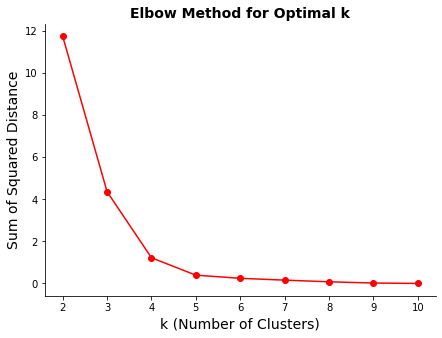

In [121]:
k_range = range(2,11)  # Range of k values to test
ssd = []  # Sum of Squared Distance

for k in k_range:
    model = KMeans(n_clusters=k, random_state=0).fit(X)
    ssd.append(model.inertia_)

plt.figure(figsize=(7,5))
plt.plot(k_range, ssd, 'ro-')
plt.title('Elbow Method for Optimal k', size=14, weight='bold')
plt.xlabel('k (Number of Clusters)', size=14)
plt.ylabel('Sum of Squared Distance', size=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('elbow.png', dpi=300, bbox_inches='tight')
plt.show()

In [122]:
k = 4 # number of clusters

# Run K-Means algorithm, random_state=0 to generate reproducible results
model = KMeans(n_clusters=k, random_state=0).fit(X)
model.labels_ # Cluster labels generated for each row

array([0, 0, 0, 1, 3, 0, 0, 1, 0, 0, 0, 2, 0, 3, 0, 2, 3, 3, 0, 2, 0, 2,
       0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       3, 0, 0, 0, 3, 2, 0, 0, 0, 2, 0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 3, 3,
       3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 2, 1, 0, 3,
       0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 1, 0, 3, 0,
       0, 0, 0, 0, 1, 1, 3, 0, 1, 0, 0, 3, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       1], dtype=int32)

In [123]:
# Join dataframes to add other information
commons.insert(1, 'Cluster', model.labels_)

In [124]:
# i.e., latitude, longitude, city, district
clustered = post.join(
    commons.set_index('Subdistrict'),
    on='Subdistrict'
).reset_index(drop=True)
clustered

,Postal_Code,City,District,Subdistrict,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,75274,Kutai Kartanegara,Samboja (Semboja),Ambarawang Darat,-1.082120,116.992051,NaN,NaN,NaN,NaN,NaN,NaN
1,75274,Kutai Kartanegara,Samboja (Semboja),Ambarawang Laut,-1.082120,116.992051,NaN,NaN,NaN,NaN,NaN,NaN
2,75381,Kutai Kartanegara,Anggana,Anggana,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
3,75382,Kutai Kartanegara,Muara Badak,Badak Baru,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
4,75382,Kutai Kartanegara,Muara Badak,Badak Mekar,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
...,...,...,...,...,...,...,...,...,...,...,...,...
212,75558,Kutai Kartanegara,Tabang,Umaq Bekuay/Bekuai,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
213,75558,Kutai Kartanegara,Tabang,Umaq Dian,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
214,75558,Kutai Kartanegara,Tabang,Umaq Tukung,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
215,75561,Kutai Kartanegara,Kota Bangun,Wonosari,-0.297625,116.721218,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
#drop all rows that have any NaN values
clustered=clustered.dropna(axis=0,how='any') 
clustered

,Postal_Code,City,District,Subdistrict,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,75381,Kutai Kartanegara,Anggana,Anggana,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
3,75382,Kutai Kartanegara,Muara Badak,Badak Baru,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
4,75382,Kutai Kartanegara,Muara Badak,Badak Mekar,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
5,75391,Kutai Kartanegara,Loa Janan,Bakungan,-0.567465,117.087515,1.0,Flea Market,Indonesian Restaurant,Javanese Restaurant,Department Store,Noodle House
6,75572,Kutai Kartanegara,Tenggarong Seberang,Bangun Rejo,-0.439151,117.013672,3.0,Arcade,Snack Place,Convenience Store,Chinese Restaurant,Food Court
...,...,...,...,...,...,...,...,...,...,...,...,...
211,75553,Kutai Kartanegara,Muara Kaman,Tunjungan,-0.149484,116.917942,2.0,Coffee Shop,Café,Yoga Studio,Clothing Store,Food Court
212,75558,Kutai Kartanegara,Tabang,Umaq Bekuay/Bekuai,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
213,75558,Kutai Kartanegara,Tabang,Umaq Dian,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
214,75558,Kutai Kartanegara,Tabang,Umaq Tukung,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market


In [126]:
clustered.index = range(len(clustered))
clustered

,Postal_Code,City,District,Subdistrict,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,75381,Kutai Kartanegara,Anggana,Anggana,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
1,75382,Kutai Kartanegara,Muara Badak,Badak Baru,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
2,75382,Kutai Kartanegara,Muara Badak,Badak Mekar,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
3,75391,Kutai Kartanegara,Loa Janan,Bakungan,-0.567465,117.087515,1.0,Flea Market,Indonesian Restaurant,Javanese Restaurant,Department Store,Noodle House
4,75572,Kutai Kartanegara,Tenggarong Seberang,Bangun Rejo,-0.439151,117.013672,3.0,Arcade,Snack Place,Convenience Store,Chinese Restaurant,Food Court
...,...,...,...,...,...,...,...,...,...,...,...,...
178,75553,Kutai Kartanegara,Muara Kaman,Tunjungan,-0.149484,116.917942,2.0,Coffee Shop,Café,Yoga Studio,Clothing Store,Food Court
179,75558,Kutai Kartanegara,Tabang,Umaq Bekuay/Bekuai,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
180,75558,Kutai Kartanegara,Tabang,Umaq Dian,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
181,75558,Kutai Kartanegara,Tabang,Umaq Tukung,-0.144614,115.569558,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market


#### Visualizing Clusters

In [127]:
# Define latitude 
kal_lat, kal_lng = -0.439151, 116.917942

# Create a map 
map_clusters = folium.Map(
    location=[kal_lat, kal_lng],
    zoom_start=11,
)

# Set color scheme for the different clusters
x = np.arange(k)  # k = number of clusters
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers and popups to the map
for lat, lng, subd, dis, city, clust in zip(
    clustered['Latitude'],
    clustered['Longitude'],
    clustered['Subdistrict'],
    clustered['District'],
    clustered['City'],
    clustered['Cluster']):
    
    label = folium.Popup(f'Cluster {clust}: {subd}, {dis}, {city}')
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(clust)-1],
        fill=True,
        fill_color=rainbow[int(clust)-1],
        fill_opacity=0.7,
    ).add_to(map_clusters)

map_clusters # Display the map

In [128]:
map_clusters.save('folium-map-clusters.html')  # Save the map

### Examining Each Cluster

#### Cluster 0 (Red)

In [129]:
# A list of column index number for reordering purpose
clust_check_cols = [3, 2, 1] + list(range(6, clustered.shape[1]))

# Filter only Cluster 0 
cluster0 = clustered.loc[
    clustered['Cluster'] == 0,
    clustered.columns[clust_check_cols]
].reset_index(drop=True)
cluster0.head()

,Subdistrict,District,City,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Anggana,Anggana,Kutai Kartanegara,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
1,Badak Baru,Muara Badak,Kutai Kartanegara,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
2,Badak Mekar,Muara Badak,Kutai Kartanegara,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
3,Baru (Kampung Baru),Tenggarong,Kutai Kartanegara,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
4,Batu Batu,Muara Badak,Kutai Kartanegara,0.0,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market


In [130]:
# Find a city where Cluster 0 is highly concentrated
cluster0.groupby('District')['Cluster'].count().sort_values(ascending=False)

District
Tabang               18
Loa Kulu             15
Sebulu               13
Muara Muntai         13
Muara Badak          13
Tenggarong           11
Marang Kayu          11
Kenohan               9
Muara Wis             7
Anggana               7
Sanga-Sanga           3
Muara Jawa            3
Samboja (Semboja)     1
Kota Bangun           1
Name: Cluster, dtype: int64

In [131]:
cluster0.iloc[:,4:].describe()  # Statistical summary

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,125,125,125,125,125
unique,1,1,1,1,1
top,Soccer Field,Yoga Studio,Chinese Restaurant,Food Court,Flea Market
freq,125,125,125,125,125


In [132]:
# Filter the no. 1 most common venues in the cluster 
top1_cluster0 = cluster0.iloc[:, 4].value_counts().reset_index()
top1_cluster0.columns = ['1st Most Common Venue', 'Count']
top1_cluster0

,1st Most Common Venue,Count
0,Soccer Field,125


#### Cluster 1 (Purple)

In [133]:
cluster1 = clustered.loc[
    clustered['Cluster'] == 1,
    clustered.columns[clust_check_cols]
].reset_index(drop=True)
cluster1.head()

,Subdistrict,District,City,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bakungan,Loa Janan,Kutai Kartanegara,1.0,Flea Market,Indonesian Restaurant,Javanese Restaurant,Department Store,Noodle House
1,Batuah,Loa Janan,Kutai Kartanegara,1.0,Flea Market,Indonesian Restaurant,Javanese Restaurant,Department Store,Noodle House
2,Handil Baru Darat,Samboja (Semboja),Kutai Kartanegara,1.0,Hotel,Café,Fast Food Restaurant,Arcade,Convenience Store
3,Kampung Lama,Samboja (Semboja),Kutai Kartanegara,1.0,Hotel,Café,Fast Food Restaurant,Arcade,Convenience Store
4,Loa Duri Ilir,Loa Janan,Kutai Kartanegara,1.0,Flea Market,Indonesian Restaurant,Javanese Restaurant,Department Store,Noodle House


In [134]:
cluster1.groupby('District')['Cluster'].count().sort_values(ascending=False)

District
Loa Janan            8
Samboja (Semboja)    4
Tenggarong           3
Tabang               1
Sebulu               1
Anggana              1
Name: Cluster, dtype: int64

In [135]:
cluster1.iloc[:,4:].describe()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,18,18,18,18,18
unique,6,6,6,6,6
top,Flea Market,Indonesian Restaurant,Javanese Restaurant,Department Store,Noodle House
freq,8,8,8,8,8


In [136]:
top1_cluster1 = cluster1.iloc[:, 4].value_counts().reset_index()
top1_cluster1.columns = ['1nd Most Common Venue', 'Count']
top1_cluster1

,1nd Most Common Venue,Count
0,Flea Market,8
1,Hotel,5
2,Arts & Crafts Store,2
3,Asian Restaurant,1
4,Diner,1
5,Café,1


#### Cluster 2 (Cyan)

In [137]:
cluster2 = clustered.loc[
    clustered['Cluster'] == 2,
    clustered.columns[clust_check_cols]
].reset_index(drop=True)
cluster2.head()

,Subdistrict,District,City,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Benua Puhun,Muara Kaman,Kutai Kartanegara,2.0,Coffee Shop,Café,Yoga Studio,Clothing Store,Food Court
1,Bukit Jering,Muara Kaman,Kutai Kartanegara,2.0,Coffee Shop,Café,Yoga Studio,Clothing Store,Food Court
2,Bunga Jadi,Muara Kaman,Kutai Kartanegara,2.0,Coffee Shop,Café,Yoga Studio,Clothing Store,Food Court
3,Cipari Makmur,Muara Kaman,Kutai Kartanegara,2.0,Coffee Shop,Café,Yoga Studio,Clothing Store,Food Court
4,Kupang Baru,Muara Kaman,Kutai Kartanegara,2.0,Coffee Shop,Café,Yoga Studio,Clothing Store,Food Court


In [138]:
cluster2.groupby('District')['Cluster'].count().sort_values(ascending=False)

District
Muara Kaman    20
Kota Bangun     1
Name: Cluster, dtype: int64

In [139]:
cluster2.iloc[:,4:].describe()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,21,21,21,21,21
unique,1,1,1,1,1
top,Coffee Shop,Café,Yoga Studio,Clothing Store,Food Court
freq,21,21,21,21,21


In [140]:
top1_cluster2 = cluster2.iloc[:, 4].value_counts().reset_index()
top1_cluster2.columns = ['1nd Most Common Venue', 'Count']
top1_cluster2

,1nd Most Common Venue,Count
0,Coffee Shop,21


#### Cluster 3 (Yellow)

In [141]:
cluster3 = clustered.loc[
    clustered['Cluster'] == 3,
    clustered.columns[clust_check_cols]
].reset_index(drop=True)
cluster3.head()

,Subdistrict,District,City,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bangun Rejo,Tenggarong Seberang,Kutai Kartanegara,3.0,Arcade,Snack Place,Convenience Store,Chinese Restaurant,Food Court
1,Buana Jaya,Tenggarong Seberang,Kutai Kartanegara,3.0,Arcade,Snack Place,Convenience Store,Chinese Restaurant,Food Court
2,Bukit Pariaman,Tenggarong Seberang,Kutai Kartanegara,3.0,Arcade,Snack Place,Convenience Store,Chinese Restaurant,Food Court
3,Bukit Raya,Tenggarong Seberang,Kutai Kartanegara,3.0,Arcade,Snack Place,Convenience Store,Chinese Restaurant,Food Court
4,Embalut,Tenggarong Seberang,Kutai Kartanegara,3.0,Arcade,Snack Place,Convenience Store,Chinese Restaurant,Food Court


In [142]:
cluster3.groupby('District')['Cluster'].count().sort_values(ascending=False)

District
Tenggarong Seberang    18
Muara Jawa              1
Name: Cluster, dtype: int64

In [143]:
cluster3.iloc[:,4:].describe()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,19,19,19,19,19
unique,1,2,2,2,2
top,Arcade,Snack Place,Convenience Store,Chinese Restaurant,Food Court
freq,19,17,17,17,17


In [144]:
top1_cluster3 = cluster3.iloc[:, 4].value_counts().reset_index()
top1_cluster3.columns = ['1nd Most Common Venue', 'Count']
top1_cluster3

,1nd Most Common Venue,Count
0,Arcade,19


### Concentration of Soccer Feilds in East Kalimantan 

In [156]:
# Find the sum of all venues in a given city
oh_city = pd.get_dummies(kalvenues['Category'], prefix="", prefix_sep="")
oh_city['City'] = kalvenues['City'] 
oh_city = oh_city.groupby('City').sum().reset_index()

# Filter the soccer field
soccerfield_city = oh_city[['City', 'Soccer Field']].sort_values(
    'Soccer Field', ascending=False
).reset_index(drop=True)
soccerfield_city

,City,Soccer Field
0,Kutai Kartanegara,129


In [146]:
# Find the sum of all venues in a given district
oh_city = pd.get_dummies(kalvenues['Category'], prefix="", prefix_sep="")
oh_city['District'] = kalvenues['District'] 
oh_city = oh_city.groupby('District').sum().reset_index()

# Filter the soccer field
soccerfield_district = oh_city[['District', 'Soccer Field']].sort_values(
    'District', ascending=False
).reset_index(drop=True)
soccerfield_district

,District,Soccer Field
0,Tenggarong Seberang,0
1,Tenggarong,12
2,Tabang,19
3,Sebulu,14
4,Sanga-Sanga,3
5,Samboja (Semboja),1
6,Muara Wis,7
7,Muara Muntai,13
8,Muara Kaman,0
9,Muara Jawa,4


The following districts have a high number of soccer fields:

In [147]:
soccerfield_district.head(10)

,District,Soccer Field
0,Tenggarong Seberang,0
1,Tenggarong,12
2,Tabang,19
3,Sebulu,14
4,Sanga-Sanga,3
5,Samboja (Semboja),1
6,Muara Wis,7
7,Muara Muntai,13
8,Muara Kaman,0
9,Muara Jawa,4


The following districts have a low number of soccer fields:

In [148]:
soccerfield_district.tail(10)

,District,Soccer Field
6,Muara Wis,7
7,Muara Muntai,13
8,Muara Kaman,0
9,Muara Jawa,4
10,Muara Badak,13
11,Marang Kayu,11
12,Loa Kulu,15
13,Loa Janan,0
14,Kenohan,9
15,Anggana,8


### Visualizing Distribution of Soccer Field Locations

In [149]:
soccerfield = kalvenues.drop(['Latitude', 'Longitude'], axis=1)
soccerfield = soccerfield.loc[(soccerfield['Category'] == 'Soccer Field')]
print(f'Dataframe shape: {soccerfield.shape[0]} rows, {soccerfield.shape[1]} columns.')
soccerfield.head(10)

Dataframe shape: 129 rows, 7 columns.


,City,District,Subdistrict,Venue,Category,Venue_Lat,Venue_Lng
0,Kutai Kartanegara,Anggana,Anggana,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
1,Kutai Kartanegara,Muara Badak,Badak Baru,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
2,Kutai Kartanegara,Muara Badak,Badak Mekar,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
11,Kutai Kartanegara,Tenggarong,Baru (Kampung Baru),Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
12,Kutai Kartanegara,Muara Badak,Batu Batu,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
18,Kutai Kartanegara,Muara Muntai,Batuq,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
19,Kutai Kartanegara,Sebulu,Beloro,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
20,Kutai Kartanegara,Tenggarong,Bendang Raya,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
23,Kutai Kartanegara,Tabang,Bila Talang,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
27,Kutai Kartanegara,Tenggarong,Bukit Biru,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268


Createing the GeoJSON file containing boundaries from [geojson.io](https://geojson.io/#map=2/20.0/0.0).

In [150]:
from google.colab import files
a = files.upload()

Saving kal.geojson to kal.geojson


In [157]:
# Create a map centered on East Kalimantan 
map_soccerfield = folium.Map(
    location=[kal_lat, kal_lng],
    zoom_start=11,
)

# East Kalimantan city boundaries
with open('map.geojson') as file:
    kal_city_bounds = json.load(file)

folium.Choropleth(
    geo_data=kal_city_bounds,
    data=soccerfield_city,
    columns=['City','Soccer Field'],
    key_on='feature.properties.name',
    fill_color='YlOrBr',
    fill_opacity=0.5,
    line_opacity=0.5,
    legend_name='Number of Soccer Fields in Kutai Kartanegara',
    reset=True,
).add_to(map_soccerfield)

for name, sub, dis, city, lat, lng in zip(
    soccerfield['Venue'],
    soccerfield['Subdistrict'],
    soccerfield['District'],
    soccerfield['City'],
    soccerfield['Venue_Lat'],
    soccerfield['Venue_Lng']):
    
    label = folium.Popup(f'{name}, {sub}, {dis}, {city}')
    
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='darkred',
        fill=True,
        fill_color='darkred',
        fill_opacity=1,
    ).add_to(map_soccerfield)

map_soccerfield

In [158]:
soccerfield

,City,District,Subdistrict,Venue,Category,Venue_Lat,Venue_Lng
0,Kutai Kartanegara,Anggana,Anggana,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
1,Kutai Kartanegara,Muara Badak,Badak Baru,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
2,Kutai Kartanegara,Muara Badak,Badak Mekar,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
11,Kutai Kartanegara,Tenggarong,Baru (Kampung Baru),Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
12,Kutai Kartanegara,Muara Badak,Batu Batu,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
...,...,...,...,...,...,...,...
460,Kutai Kartanegara,Kenohan,Tubuhan,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
461,Kutai Kartanegara,Tabang,Tukung Ritan,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
464,Kutai Kartanegara,Tabang,Umaq Bekuay/Bekuai,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268
465,Kutai Kartanegara,Tabang,Umaq Dian,Stadion Santiago Berdebu,Soccer Field,-0.143411,115.571268


In [159]:
map_soccerfield.save('folium-map-soccerfield.html')

## Results and Discussion

A total of 512 venues from Kutai Kartanegara city were returned at the time the API call was made. There are on average 2 venues within a kilometer of a subdistrict center, where two of the most common categories overall is soccer fields which we are interested.

After deciding on an optimal k value of 4, K-Means algorithm was run to cluster the subdistricts based on their most common surrounding venues. Each of the four clusters, labeled 0-3, is characterized by a dominant venue as follows:

Cluster|Member|#1 Common Venues|Highly Concentrated District
-|-|-|-
0|125|Soccer Field|Tabang
1|18|Flea Market|Loa Janan
2|21|Coffee Shop|Muara Kaman
3|19|Arcade|Tenggarong Seberang



A considerable number of soccer fields can be found within Cluster 0 (125 shops). In fact, it is the most common venues in that cluster. Choropleth map of soccer feld locations shows that Kutai Kartanegara has a very high concentration of the business: 129 soccer fields are located there. 

Looking at the visualizing distribution of soccer field locations, we can find out that there are three locations having most soccer fields. The districts in Kutai Kartanegara for suggestion wil be Tenggarong and Balikpapan,because Tabang's location is more inland.They can be the optons for developing and business investing.


## Conclusion

Regions in Kutai Kartanegara city were explored and then clustered based on the similarity of their surrounding venues using the K-Means algorithm. Analysis results show that Tenggarong and Balikpapan are the best candidate for developing business when moving to the new capital.

## References
1. https://bola.kompas.com/read/2019/08/26/19490918/ada-3-stadion-bertaraf-internasional-di-kawasan-kalimantan-timur?page=all 
2. https://www.upmedia.mg/news_info.php?SerialNo=94965
3. https://www.cw.com.tw/article/5096752